In [5]:
%%writefile combined_app.cpp
#include <iostream>
#include <vector>
#include <numeric>
#include <cmath>
#include <iomanip>
#include <fstream>
#include <sstream>
#include <string>
#include <random>

/**
 * @file combined_app.cpp
 * @brief Generates synthetic spring data, saves it to CSV, and immediately analyzes it.
 * @author Ryan Adidaru
 * @NPM 2306266994
 */

// --- Data Generation Function ---
void generate_data_to_file(const std::string& filename, double k_true, int num_points, double noise_level) {
    std::random_device rd;
    std::mt19937 gen(rd());
    std::normal_distribution<> d(0, noise_level);
    std::ofstream file(filename);
    file << "displacement_m,force_N\n";
    std::cout << "Generating " << num_points << " data points..." << std::endl;
    for (int i = 1; i <= num_points; ++i) {
        double x = i * 0.025;
        double y_perfect = k_true * x;
        double y_noisy = y_perfect + d(gen);
        file << std::fixed << std::setprecision(4) << x << "," << y_noisy << "\n";
    }
    file.close();
    std::cout << "Data successfully generated and saved to " << filename << std::endl;
}

// --- Analysis Function ---
struct RegressionResult { double slope, intercept, r_squared; };
RegressionResult linearRegression(const std::vector<double>& x, const std::vector<double>& y) {
    int n = x.size();
    if (n == 0) return {0, 0, 0};
    double sum_x = std::accumulate(x.begin(), x.end(), 0.0);
    double sum_y = std::accumulate(y.begin(), y.end(), 0.0);
    double sum_xy = std::inner_product(x.begin(), x.end(), y.begin(), 0.0);
    double sum_x_sq = std::inner_product(x.begin(), x.end(), x.begin(), 0.0);
    double slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x_sq - sum_x * sum_x);
    double mean_x = sum_x / n;
    double mean_y = sum_y / n;
    double intercept = mean_y - slope * mean_x;
    double ss_tot = 0.0, ss_res = 0.0;
    for (int i = 0; i < n; ++i) {
        ss_res += pow(y[i] - (intercept + slope * x[i]), 2);
        ss_tot += pow(y[i] - mean_y, 2);
    }
    double r_squared = (ss_tot > 0) ? (1.0 - (ss_res / ss_tot)) : 1.0;
    return {slope, intercept, r_squared};
}

int main() {
    // --- Part 1: Generate Data ---
    const std::string filename = "data.csv";
    generate_data_to_file(filename, 200.0, 20, 1.5);

    // --- Part 2: Read and Analyze Data ---
    std::cout << "\n--- Starting Analysis ---\n";
    std::ifstream file(filename);
    if (!file.is_open()) {
        std::cerr << "Error: Could not open " << filename << std::endl;
        return 1;
    }
    std::vector<double> x_data, y_data;
    std::string line, word;
    std::getline(file, line); // Skip header
    while (std::getline(file, line)) {
        std::stringstream ss(line);
        std::getline(ss, word, ',');
        x_data.push_back(std::stod(word));
        std::getline(ss, word, ',');
        y_data.push_back(std::stod(word));
    }
    file.close();

    RegressionResult result = linearRegression(x_data, y_data);

    // --- Part 3: Print Results ---
    std::cout << "==========================================================" << std::endl;
    std::cout << "      Combined C++ App: Analysis Results                  " << std::endl;
    std::cout << "==========================================================" << std::endl;
    std::cout << std::fixed << std::setprecision(3);
    std::cout << "Data Points (n)           : " << x_data.size() << std::endl;
    std::cout << "----------------------------------------------------------" << std::endl;
    std::cout << "Konstanta Pegas (k) [Slope]: " << result.slope << " N/m" << std::endl;
    std::cout << "Intercept (a0)              : " << result.intercept << " N" << std::endl;
    std::cout << "----------------------------------------------------------" << std::endl;
    std::cout << "Koefisien Determinasi (R^2): " << result.r_squared << std::endl;
    std::cout << "==========================================================" << std::endl;

    return 0;
}

Writing combined_app.cpp


In [7]:
!g++ combined_app.cpp -o combined_app
!./combined_app

Generating 20 data points...
Data successfully generated and saved to data.csv

--- Starting Analysis ---
      Combined C++ App: Analysis Results                  
Data Points (n)           : 20
----------------------------------------------------------
Konstanta Pegas (k) [Slope]: 200.232 N/m
Intercept (a0)              : 0.225 N
----------------------------------------------------------
Koefisien Determinasi (R^2): 0.998


Successfully loaded data.csv into Python.

      Python Analysis and Visualization Results           
Konstanta Pegas (k) [Slope]: 200.232 N/m
Intercept (a0)              : 0.225 N
Koefisien Determinasi (R^2): 0.998


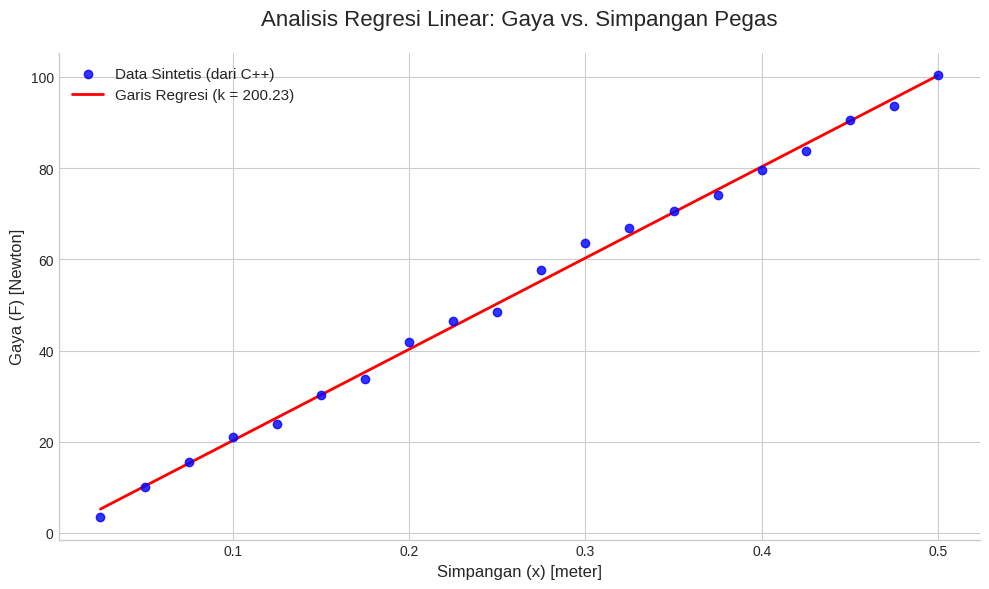

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Read the data generated by the C++ program
try:
    df = pd.read_csv('data.csv')
    print("Successfully loaded data.csv into Python.\n")
except FileNotFoundError:
    print("Error: data.csv not found. Please run the C++ cells first.")
    # Stop execution if file doesn't exist
    exit()

# Prepare data for Scikit-learn
# .values converts the pandas Series to a NumPy array
# .reshape(-1, 1) converts the 1D array to a 2D column vector
X = df['displacement_m'].values.reshape(-1, 1)
y = df['force_N'].values

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Extract results
slope_py = model.coef_[0]
intercept_py = model.intercept_
r_squared_py = model.score(X, y)

# Print Python analysis results for comparison
print("==========================================================")
print("      Python Analysis and Visualization Results           ")
print("==========================================================")
print(f"Konstanta Pegas (k) [Slope]: {slope_py:.3f} N/m")
print(f"Intercept (a0)              : {intercept_py:.3f} N")
print(f"Koefisien Determinasi (R^2): {r_squared_py:.3f}")
print("==========================================================")

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for the raw data
ax.scatter(X, y, color='blue', label='Data Sintetis (dari C++)', zorder=5, alpha=0.8)

# Line plot for the regression model
ax.plot(X, model.predict(X), color='red', linewidth=2, label=f'Garis Regresi (k = {slope_py:.2f})')

# Formatting the plot
ax.set_title('Analisis Regresi Linear: Gaya vs. Simpangan Pegas', fontsize=16, pad=20)
ax.set_xlabel('Simpangan (x) [meter]', fontsize=12)
ax.set_ylabel('Gaya (F) [Newton]', fontsize=12)
ax.legend(fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()